# SOFTMAX REGRESSION FROM SCRATCH

In [96]:
import numpy as np
from my_extensions import MyExtensions
from sklearn.datasets import fetch_openml

# IMPORT MNIST DATA
mnist = fetch_openml("mnist_784", version=1)
X, y = np.array(mnist["data"]), np.array(mnist["target"])


In [97]:
# SPLIT DATA INTO TRAINING AND TESTING SETS
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]



In [98]:
# NORMALIZE DATA
X_train = X_train / 255
X_test = X_test / 255



In [99]:

# SOFTMAX FUNCTION
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums


# CROSS-ENTROPY LOSS FUNCTION
def cross_entropy_loss(y, y_proba):
    loss = -np.mean(np.sum(y * np.log(y_proba + 1e-7), axis=1))
    return loss


# CREATE SOFTMAX REGRESSION MODEL FROM SCRATCH
# Inherit from the Extension class to use its methods for visualization and evaluation
class MySoftmaxRegression(MyExtensions):
    def __init__(self, n_inputs, n_outputs, learning_rate=0.1, n_iterations=1000):
        super().__init__()
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.thetas = []
        self.losses = []

    def fit(self, X, y):
        """
        Fit the model to the data X and y. Meaning let the model learn the parameters.
        :param X: Features
        :param y: Labels
        :return: None
        """

        n_samples = len(X)
        
        # one-hot encode the labels (example in a cell below)
        Y = np.eye(self.n_outputs)[y.astype(int)]

        # initialize the parameters with random values
        self.thetas = np.random.randn(self.n_inputs, self.n_outputs)

        # gradient descent
        for iteration in range(self.n_iterations):
            # compute linear model / linear predictions
            linear_model = np.dot(X, self.thetas)

            # apply softmax function to get probabilities
            y_prediction = softmax(linear_model)

            # compute the cost (only for visualization, not used in the optimization process)
            loss = cross_entropy_loss(Y, y_prediction)
            self.losses.append(loss)
            
            # compute the gradients
            # gradients = 1 / n_samples * X.T.dot(y_prediction - Y)
            gradients = 2 / n_samples * np.dot(X.T, (y_prediction - Y))

            # update the parameters
            self.thetas = self.thetas - self.learning_rate * gradients

    def predict(self, X):
        """
        Predict the class labels for the provided data
        :param X: Features
        :return: Predicted class labels
        """
        logits = X.dot(self.thetas)
        return softmax(logits)


In [100]:
# 4 - we specify that we are working with 4 classes
# [0, 1, 2, 3, 3, 2, 1, 0] - Array we want to one-hot encode
Y = np.eye(4)[[0, 1, 2, 3, 3, 2, 1, 0]]
Y

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [101]:
# TRAIN THE MODEL (Takes 10 minutes to run. If you want to make it faster, then implement mini-batch gradient descent or SGD, instead of batch gradient descent)

model = MySoftmaxRegression(n_inputs=X_train.shape[1],
                            n_outputs=len(np.unique(y_train)), 
                            learning_rate=0.1,
                            n_iterations=10_000)
model.fit(X_train, y_train)

In [102]:
# show the parameters
print("Best parameters:")
model.show_parameters()

Best parameters:


array([[-0.26735976, -0.30268004,  0.24949642, ...,  0.43122706,
         0.4386377 , -1.30287216],
       [ 0.68664682,  1.11736219,  1.09781519, ..., -0.99585522,
         1.65586955, -0.3970676 ],
       [-0.36309958,  1.81316033,  0.9719866 , ...,  0.21794777,
         0.98464085,  0.04448919],
       ...,
       [-0.73070498, -1.40061063, -0.50091949, ...,  0.59936691,
        -2.07766886, -0.4330983 ],
       [ 0.31921249,  0.07959058,  0.39922844, ...,  0.12039863,
         0.62625179,  0.88664884],
       [ 0.30856175, -2.70425638, -0.37100413, ...,  0.89203323,
         0.04207746,  0.25968729]])

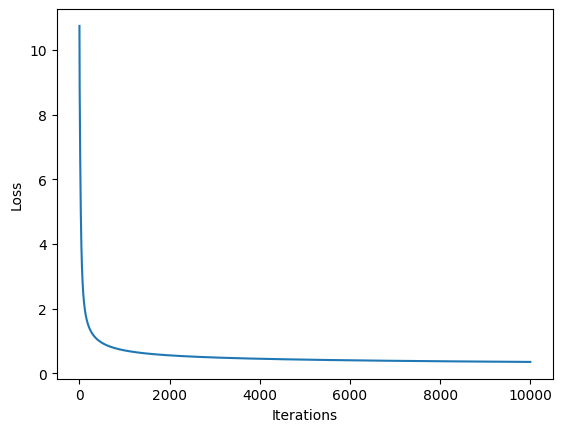

In [103]:
# VISUALIZE THE MODEL

model.show_loss_curve()

In [104]:
y_pred = model.predict(X_test)

accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test.astype(int))
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


In [ ]:
# todo: Add also column of 1s due to it being regression? (bias)